# Notebook preparation

In [1]:
import datetime
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from matplotlib.dates import DateFormatter
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

/Users/Jan/opt/anaconda3/envs/data-mining/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Jan/opt/anaconda3/envs/data-mining/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Data analysis

In [2]:
infos = pd.read_csv('../data/infos.csv', sep='|')
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [70]:
items = pd.read_csv('../data/items.csv', sep='|')
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [4]:
orders = pd.read_csv('../data/orders.csv', sep='|')
orders['time'] = pd.to_datetime(orders.time)
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [5]:
# change date to aggregate on daily basis
orders['time'] = orders['time'].dt.strftime('%Y-%m-%d')

# aggregate 'order' and 'salesPrice' per product 
agg_orders = orders.groupby('itemID', as_index=False).agg({'order': 'sum', 'salesPrice': 'sum'})

# order by 'order'
top_order_number = agg_orders.sort_values(by=['order'], ascending=False)
top_order_number = top_order_number.reset_index(drop=True)

# order by 'salesPrice'
top_sales_price = agg_orders.sort_values(by=['salesPrice'], ascending=False)
top_sales_price = top_sales_price.reset_index(drop=True)

## Data distribution and top products

In [6]:
# most ordered products
top_order_number.head(10)

,itemID,order,salesPrice
0,7789,12184,100413.99
1,5035,11908,369170.19
2,5117,9100,156487.53
3,4297,8675,29062.80
4,5039,8444,21543.41
5,4208,8101,92245.44
6,4322,7511,114211.74
7,5122,7430,20690.68
8,8006,7263,9321.28
9,4931,7104,56679.68


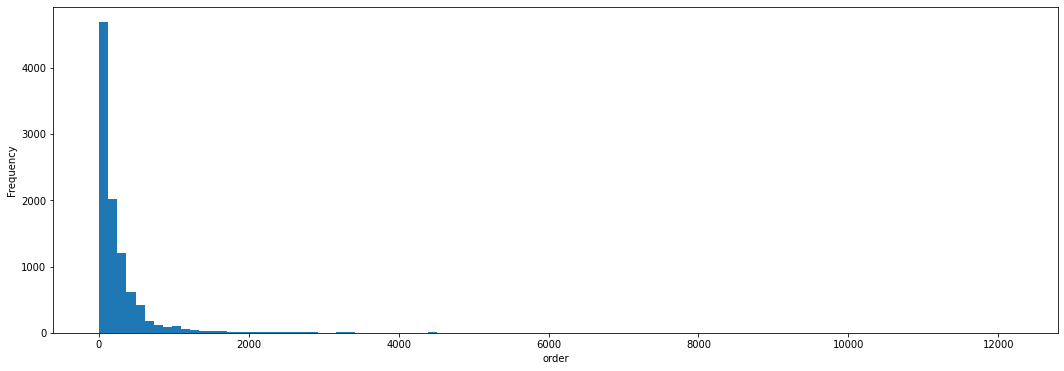

In [7]:
# 'order' distribution
plot = top_order_number['order'].plot(kind='hist', bins=100, figsize=(18, 6))
plot.set_xlabel('order')
plt.show()

In [8]:
# products with the highest revenue
top_sales_price.head(10)

,itemID,order,salesPrice
0,672,366,515476.81
1,320,662,504417.56
2,35,1508,502826.32
3,7625,304,433909.36
4,4965,1470,410743.93
5,4588,256,409085.07
6,5035,11908,369170.19
7,4426,1049,325786.65
8,7661,67,257203.62
9,9377,60,250413.37


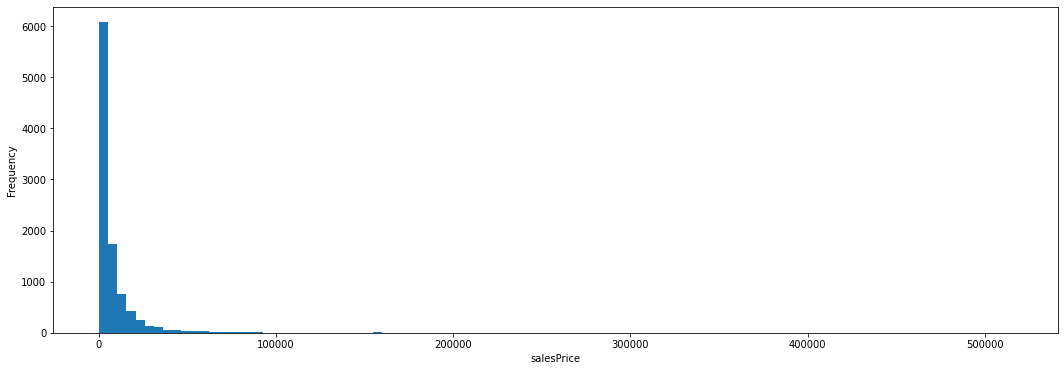

In [9]:
# 'order' distribution
plot = top_sales_price['salesPrice'].plot(kind='hist', bins=100, figsize=(18, 6))
plot.set_xlabel('salesPrice')
plt.show()

In [10]:
# aggregate 'order' and 'salesPrice' per day per product
agg_orders = orders.groupby(['itemID', 'time']).agg({'order': 'sum', 'salesPrice': 'sum'})

# aggregate 'order' and 'salesPrice' per product
agg_orders_items = orders.groupby('itemID', as_index=False).agg({'order': 'sum', 'salesPrice': 'sum'})

# aggregate 'order' and 'salesPrice' per week per product
orders_weekly = orders.copy()
orders_weekly['week'] = orders_weekly['time'].astype(np.datetime64).dt.week
agg_orders_weekly = orders_weekly.groupby(['itemID', 'week']).agg({'order': 'sum', 'salesPrice': 'sum'})

# aggregate 'order' and 'salesPrice' per day
agg_orders_all = orders.groupby(['time']).agg({'order': 'sum', 'salesPrice': 'sum'})
agg_orders

order  salesPrice
itemID time                         
1      2018-01-23      1        3.11
       2018-01-25      1        3.11
       2018-01-29    307      789.94
       2018-01-30      3        9.33
       2018-01-31      1        3.11
...                  ...         ...
10450  2018-06-29      2       88.96
10459  2018-05-05      1       14.71
10460  2018-04-16      1      325.67
10462  2018-04-22      1      304.30
10463  2018-05-25      1      282.16

[100148 rows x 2 columns]

## Category analysis

In [11]:
extended_items = pd.merge(items, agg_orders_items, how='left', on=['itemID'])
extended_items = extended_items.fillna(0)

In [12]:
# sales price of 'category1'
extended_items.groupby('category1')['salesPrice'].describe()

,count,mean,std,min,25%,50%,75%,max
category1,,,,,,,,
1,1823.0,7960.229161,24823.719570,0.0,822.6000,2886.10,7949.1950,515476.81
2,2348.0,6443.515724,9012.918264,0.0,1095.6775,3288.28,8176.9850,137061.71
3,300.0,14407.924000,40709.642558,0.0,672.5300,2556.85,12419.9775,433909.36
4,969.0,8263.270433,15776.718524,0.0,775.6000,3006.83,8522.8800,159607.87
5,1679.0,7830.528684,20816.769858,0.0,419.2000,2478.05,7758.1600,410743.93
6,489.0,7528.650000,24635.471842,0.0,327.0500,2212.18,6171.1800,409085.07
7,1121.0,4006.645263,9297.136286,0.0,71.6700,792.54,4146.0700,109423.15
8,1734.0,9657.460652,17229.134736,0.0,1227.3375,4136.94,10977.3800,250413.37


In [13]:
# top 'category1' categories
category1 = extended_items.groupby('category1').agg({'salesPrice': 'sum'})
category1.sort_values(by=['salesPrice'], ascending=False).head(10)

,salesPrice
category1,
8,16746036.77
2,15129374.92
1,14511497.76
5,13147457.66
4,8007109.05
7,4491449.34
3,4322377.20
6,3681509.85


In [ ]:
# number of orders per day (all products)
item = agg_orders_all.copy()
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['order'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('#orders')
plt.show()

In [14]:
# sales price of 'category2'
extended_items.groupby('category2')['salesPrice'].describe()

,count,mean,std,min,25%,50%,75%,max
category2,,,,,,,,
1,641.0,8671.711076,31895.857104,0.00,791.1000,2858.550,8021.4800,504417.56
2,64.0,3824.222344,3887.314983,0.00,636.7125,2580.400,5363.5375,17746.69
3,134.0,7504.060224,15783.407015,0.00,658.8550,2511.465,6695.2750,116007.32
4,252.0,8279.443730,18805.195563,0.00,719.7300,2606.485,7063.7250,158007.10
5,494.0,8562.967854,25441.996795,0.00,1378.0475,3624.590,9302.6025,515476.81
6,214.0,4950.454579,8372.943282,0.00,603.7675,2194.215,6344.6625,72179.10
7,24.0,13613.060000,21256.568964,0.00,1152.2775,4100.500,15954.1200,81789.23
8,1119.0,6820.754129,8683.758224,0.00,1347.7850,3744.340,9020.2150,86100.15
9,157.0,5743.232675,13692.125953,0.00,116.4400,1123.440,5742.1900,137061.71


In [51]:
# top 'category2' categories
category2 = extended_items.groupby('category2').agg({'order': 'sum', 'salesPrice': 'sum'})
category2.sort_values(by=['salesPrice'], ascending=False).head(100)

,order,salesPrice
category2,,
44,68099.0,14648442.73
8,236632.0,7632423.87
1,93689.0,5558566.80
32,353665.0,5192914.29
5,53113.0,4230106.12
10,105529.0,3716013.30
39,268797.0,3522238.11
21,244405.0,3298465.79
23,191874.0,3073327.96


In [16]:
# sales price of 'category3'
extended_items.groupby('category3')['salesPrice'].describe()

,count,mean,std,min,25%,50%,75%,max
category3,,,,,,,,
1,1823.0,7960.229161,24823.719570,0.0,822.600,2886.100,7949.195,515476.81
2,2400.0,6412.324612,8964.511577,0.0,1083.335,3266.240,8166.535,137061.71
3,646.0,7744.336409,27561.277818,0.0,101.440,1437.210,5265.855,409085.07
4,1680.0,7839.166768,20812.018705,0.0,415.910,2492.155,7800.370,410743.93
5,204.0,13387.633824,38829.165732,0.0,722.040,2248.590,12884.190,433909.36
6,1018.0,4413.109342,9998.264310,0.0,108.930,1177.310,4562.635,109423.15
7,957.0,8350.274242,15855.094314,0.0,795.440,3030.160,8593.360,159607.87
8,1735.0,9653.175314,17225.090877,0.0,1228.065,4128.880,10975.000,250413.37


In [17]:
# top 'category3' categories
category3 = extended_items.groupby('category3').agg({'salesPrice': 'sum'})
category3.sort_values(by=['salesPrice'], ascending=False).head(10)

,salesPrice
category3,
8,16748259.17
2,15389579.07
1,14511497.76
4,13169800.17
7,7991212.45
3,5002841.32
6,4492545.31
5,2731077.30


In [18]:
# sales price of all categories
extended_items.groupby(['category1', 'category2', 'category3'])['salesPrice'].describe()

count         mean           std     min  \
category1 category2 category3                                             
1         1         1          641.0  8671.711076  31895.857104    0.00   
          2         1           64.0  3824.222344   3887.314983    0.00   
          3         1          134.0  7504.060224  15783.407015    0.00   
          4         1          252.0  8279.443730  18805.195563    0.00   
          5         1          494.0  8562.967854  25441.996795    0.00   
...                              ...          ...           ...     ...   
8         48        8           23.0  8320.649565   8312.197948   81.47   
          49        8            8.0  8672.963750   7945.876765    0.00   
          50        8            9.0  2190.336667   2164.288786  117.96   
          51        8            1.0   524.670000           NaN  524.67   
          52        8            2.0   256.810000    270.128933   65.80   

                                     25%       50%         75%        max  
category1 category2 category3                                              
1         1         1           791.1000  2858.550   8021.4800  504417.56  
          2         1           636.7125  2580.400   5363.5375   17746.69  
          3         1           658.8550  2511.465   6695.2750  116007.32  
          4         1           719.7300  2606.485   7063.7250  158007.10  
          5         1          1378.0475  3624.590   9302.6025  515476.81  
...                                  ...       ...         ...        ...  
8         48        8          1814.1550  5833.550  10306.6800   29259.44  
          49        8          3202.4350  6155.080  13301.1500   21170.97  
          50        8           589.5000   996.120   3571.2700    6568.11  
          51        8           524.6700   524.670    524.6700     524.67  
          52        8           161.3050   256.810    352.3150     447.82  

[75 rows x 8 columns]

In [41]:
# top combined categories
category_all = extended_items.groupby(['category1', 'category2', 'category3']).agg({'salesPrice': 'sum'})
category_all.sort_values(by=['salesPrice'], ascending=False).head(10)

,,,salesPrice
category1,category2,category3,
8,44,8,14648442.73
2,8,2,7632423.87
1,1,1,5558566.80
5,32,4,5192914.29
1,5,1,4230106.12
2,10,2,3716013.30
4,39,7,3522238.11
5,21,4,3298088.51
7,23,6,3037262.80


In [43]:
# sales price of all categories
pd.set_option('display.max_rows', 100)
extended_items.groupby(['category1', 'category2', 'category3']).count()

itemID  brand  manufacturer  customerRating  \
category1 category2 category3                                                
1         1         1             641    641           641             641   
          2         1              64     64            64              64   
          3         1             134    134           134             134   
          4         1             252    252           252             252   
          5         1             494    494           494             494   
          6         1             214    214           214             214   
          7         1              24     24            24              24   
2         8         2            1119   1119          1119            1119   
          9         2             157    157           157             157   
          10        2             462    462           462             462   
          11        2             506    506           506             506   
                    6               3      3             3               3   
                    8               1      1             1               1   
          13        2              46     46            46              46   
          17        2              54     54            54              54   
3         12        2              47     47            47              47   
                    3               5      5             5               5   
                    5               4      4             4               4   
          29        3              40     40            40              40   
                    4               1      1             1               1   
                    5               2      2             2               2   
                    6               2      2             2               2   
          31        5              18     18            18              18   
          34        5             180    180           180             180   
                    6               1      1             1               1   
4         14        2               6      6             6               6   
                    6               6      6             6               6   
                    7              56     56            56              56   
          38        7             305    305           305             305   
          39        7             383    383           383             383   
          40        7              68     68            68              68   
          41        7              59     59            59              59   
          42        7              86     86            86              86   
5         15        2               2      2             2               2   
                    4              45     45            45              45   
          21        3               1      1             1               1   
                    4             156    156           156             156   
          28        3               2      2             2               2   
                    4             296    296           296             296   
          30        3               3      3             3               3   
                    4              89     89            89              89   
          32        4            1085   1085          1085            1085   
6         16        2               1      1             1               1   
                    3              26     26            26              26   
          18        3              58     58            58              58   
          19        3             327    327           327             327   
                    6               2      2             2               2   
          20        3              14     14            14              14   
          22        3              54     54            54              54   
          27        3               7      7         

In [20]:
# sales price of 'brand'
extended_items.groupby('brand')['salesPrice'].describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
0,5232.0,6879.441864,21232.249346,0.00,513.0550,2332.480,6697.3300,515476.81
1,33.0,14810.447273,18090.835146,383.40,5656.3200,9043.020,14663.6200,81789.23
2,89.0,8733.270562,20788.786280,5.22,513.3800,2551.320,5914.5100,109423.15
3,8.0,2787.497500,4881.040169,18.56,210.5625,566.280,2661.1650,14254.07
4,71.0,15618.522817,16477.370892,4.21,4684.9250,10533.010,19300.0100,86100.15
...,...,...,...,...,...,...,...,...
270,1.0,0.000000,NaN,0.00,0.0000,0.000,0.0000,0.00
271,2.0,193.725000,23.864854,176.85,185.2875,193.725,202.1625,210.60
272,9.0,0.000000,0.000000,0.00,0.0000,0.000,0.0000,0.00


In [21]:
# top brands
brand = extended_items.groupby('brand').agg({'salesPrice': 'sum'})
brand.sort_values(by=['salesPrice'], ascending=False).head(10)

,salesPrice
brand,
0,35993239.83
178,2744239.48
186,1554953.25
90,1509957.13
93,1454417.47
4,1108915.12
180,1023669.54
70,1010595.12
193,969235.68


In [22]:
# sales price of 'manufacturer'
extended_items.groupby('manufacturer')['salesPrice'].describe()

,count,mean,std,min,25%,50%,75%,max
manufacturer,,,,,,,,
1,40.0,6628.234250,10699.335814,303.84,960.1250,2936.125,6393.8475,46364.70
2,343.0,4515.420700,6475.195192,0.00,878.2850,2531.800,6071.4600,73163.42
3,123.0,8161.783171,17984.713396,5.22,922.2500,3015.730,7236.7750,109423.15
4,53.0,3257.390943,4173.592751,5.86,525.6500,1545.450,4367.9800,17746.69
5,149.0,8900.306644,45850.687552,0.00,301.2400,1384.740,4270.0000,502826.32
...,...,...,...,...,...,...,...,...
249,1.0,8816.480000,NaN,8816.48,8816.4800,8816.480,8816.4800,8816.48
250,26.0,7131.429615,6747.013307,272.07,1807.6500,6184.415,10724.1975,28391.14
251,8.0,6333.196250,7933.927292,0.00,0.0000,3963.510,9731.9425,22883.82


In [23]:
# top manufacturer
manufacturer = extended_items.groupby('manufacturer').agg({'salesPrice': 'sum'})
manufacturer.sort_values(by=['salesPrice'], ascending=False).head(10)

,salesPrice
manufacturer,
80,3784534.01
128,3574273.77
86,2938459.47
225,2868030.03
194,2283877.73
159,2227539.80
100,2002327.86
19,1942602.35
121,1708263.19


## Cluster similar time series

In [71]:
# prepare clustering training data
time_series = []
item_ids = []
for name, group in agg_orders.groupby(['itemID']):
    item = agg_orders.loc[name]
    idx = pd.date_range('2018-01-01', '2018-06-29')
    item.index = pd.DatetimeIndex(item.index)
    item = item.reindex(idx, fill_value=0)
    item.index = pd.to_datetime(item.index)
    time_series.append(item['order'].to_list())
    item_ids.append(name)
time_series = to_time_series_dataset(time_series)

In [ ]:
# cluster time series using k-means algorithm
km = TimeSeriesKMeans(n_clusters=52, metric='dtw').fit(time_series)
cluster = km.predict(time_series)
cluster_df = pd.DataFrame(data={'cluster': cluster}, index=item_ids)
cluster_extended_items = pd.merge(left=extended_items, right=cluster_df.reset_index(), left_on='itemID', right_on='index')
cluster_extended_items.head(100)

In [61]:
cluster_extended_items.groupby(['category2', 'cluster']).sum()

itemID  brand  manufacturer  customerRating  category1  \
category2 cluster                                                           
1         6        466489      4          6380          945.25        587   
          24         5193      0            37            5.00          5   
          26         1700      0            14            5.00          1   
          41          996      0             8            0.00          1   
2         6         41816      0           712           93.27         60   
...                   ...    ...           ...             ...        ...   
48        6        210201    783          2944           45.67        184   
49        6         66456    803          1328           10.00         56   
50        6         81926    910          2097           19.67         72   
51        6          8867      0            23            0.00          8   
52        6         20042    505           458            0.00         16   

                   category3  recommendedRetailPrice    order  salesPrice  \
category2 cluster                                                           
1         6              587               113592.00  91024.0  5504579.12   
          24               5                  134.14   1753.0    44745.88   
          26               1                   13.73    500.0     2258.52   
          41               1                   15.48    412.0     6983.28   
2         6               60                 1407.97  10027.0   227003.54   
...                      ...                     ...      ...         ...   
48        6              184                 3877.67   1042.0   191374.94   
49        6               56                 1617.51   1046.0    69383.71   
50        6               72                  125.94   1286.0    19713.03   
51        6                8                    6.40    250.0      524.67   
52        6               16                   19.26     86.0      513.62   

                    index  
category2 cluster          
1         6        466489  
          24         5193  
          26         1700  
          41          996  
2         6         41816  
...                   ...  
48        6        210201  
49        6         66456  
50        6         81926  
51        6          8867  
52        6         20042  

[194 rows x 10 columns]

## Order frequency analysis

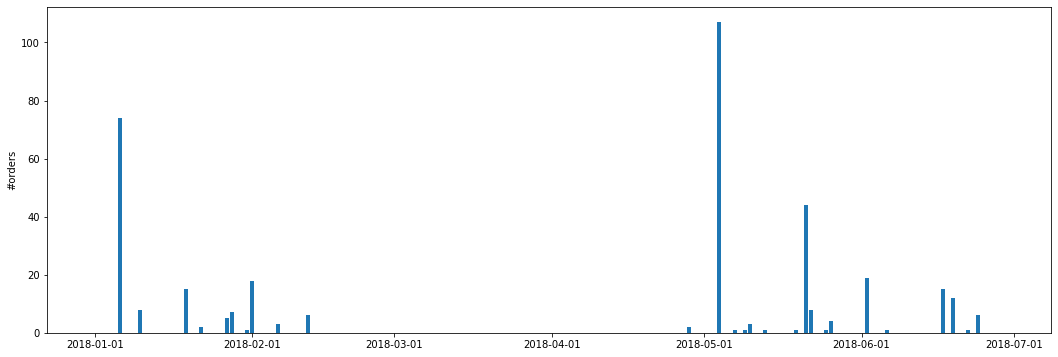

In [26]:
# number of orders per day (examplary product)
item = agg_orders.loc[672]
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['order'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('#orders')
plt.show()

In [27]:
# print all products by order frequecy
#for name, group in agg_orders.groupby(['itemID']):
#    item = agg_orders.loc[name]
#    idx = pd.date_range('2018-01-01', '2018-06-29')
#    item.index = pd.DatetimeIndex(item.index)
#    item = item.reindex(idx, fill_value=0)
#    item.index = pd.to_datetime(item.index)
#    
#    fig = plt.figure(figsize=(18, 6))
#    fig.suptitle('Product-ID: ' + str(name))
#    ax = fig.add_subplot()
#    ax.bar(item.index.values, item['order'])
#    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#    ax.set_ylabel('#orders')
#    plt.show()

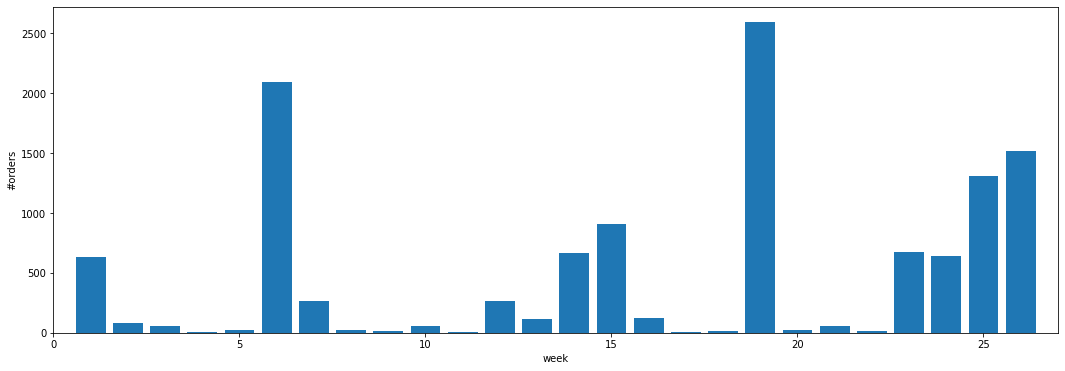

In [28]:
# number of orders per week (examplary product)
item = agg_orders_weekly.loc[7789]

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['order'])
ax.set_xlim(0, 27)
ax.set_ylabel('#orders')
ax.set_xlabel('week')
plt.show()

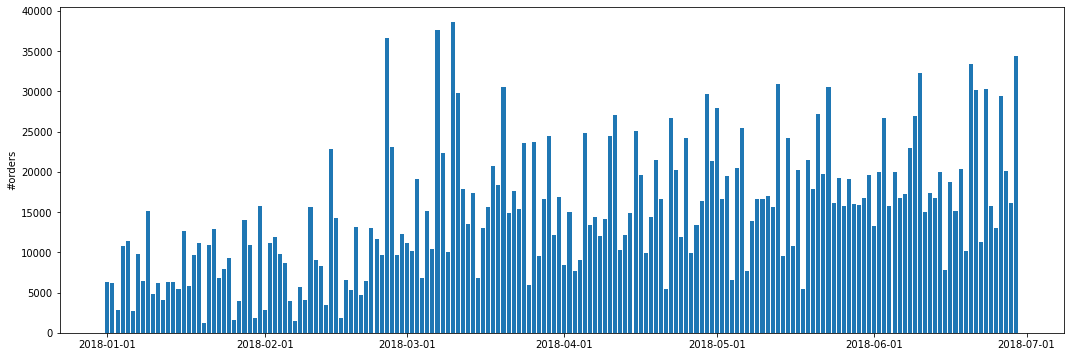

In [29]:
# number of orders per day (all products)
item = agg_orders_all.copy()
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['order'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('#orders')
plt.show()

## Revenue analysis

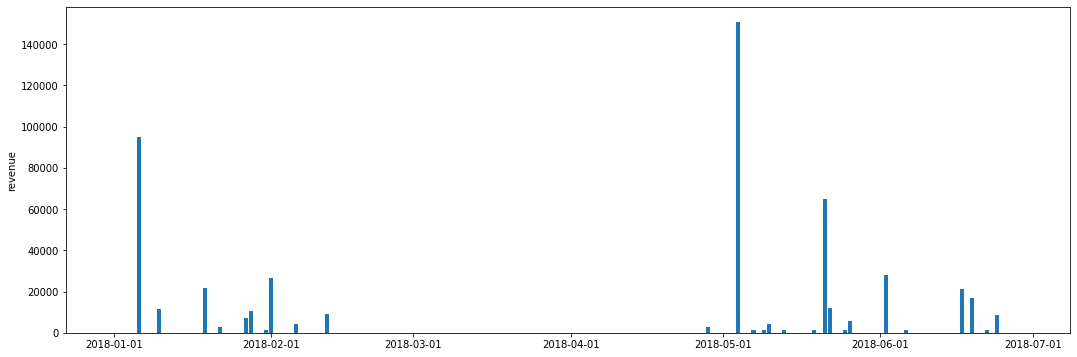

In [30]:
# revenue per day (examplary product)
item = agg_orders.loc[672]
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['salesPrice'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('revenue')
plt.show()

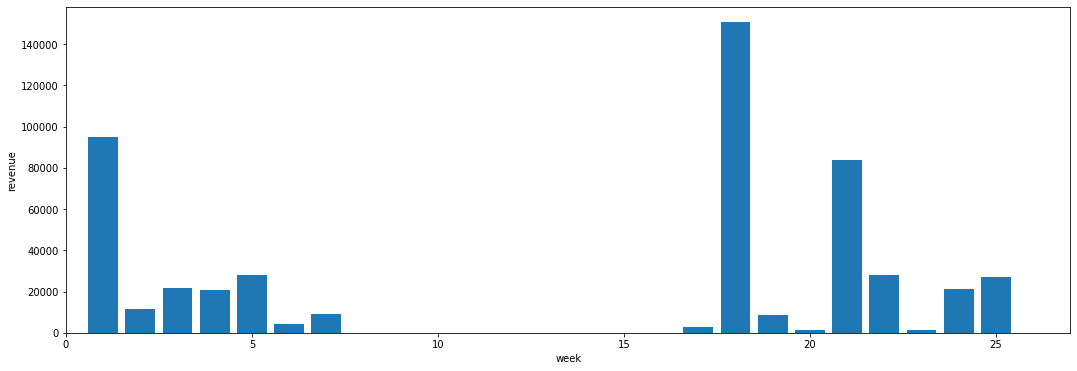

In [31]:
# revenue per week (examplary product)
item = agg_orders_weekly.loc[672]

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['salesPrice'])
ax.set_xlim(0, 27)
ax.set_ylabel('revenue')
ax.set_xlabel('week')
plt.show()

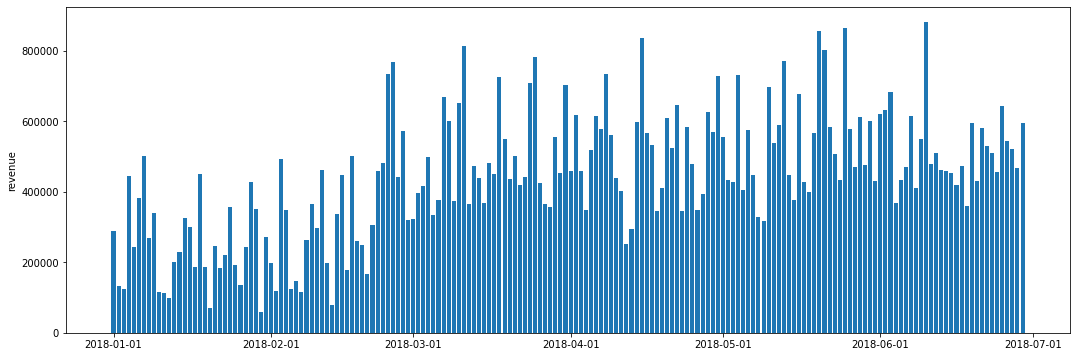

In [32]:
# revenue per day (all products)
item = agg_orders_all.copy()
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# plot figure
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(item.index.values, item['salesPrice'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('revenue')
plt.show()

## Price analysis

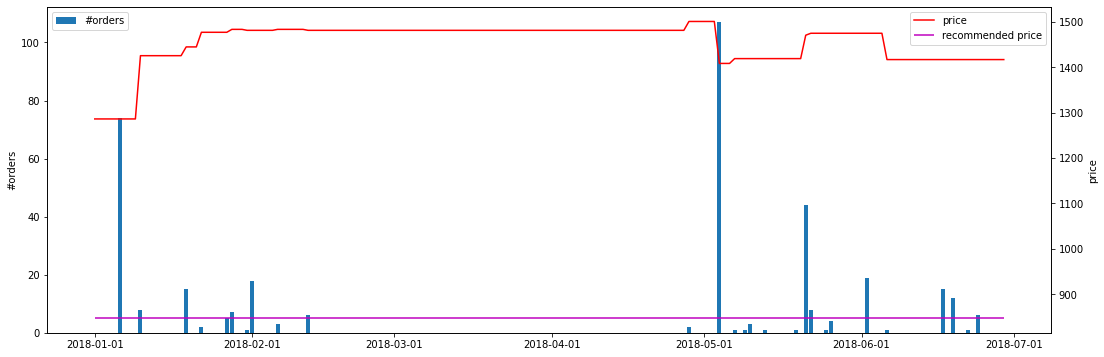

In [33]:
# sales price for a single product over time (examplary product)
item_id = 672
item = agg_orders.loc[item_id]
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)
item['price'] = item['salesPrice'] / item['order']
item = item.fillna(method='ffill')
item = item.fillna(method='bfill')

# plot figure
fig, ax1 = plt.subplots(figsize=(18, 6), sharex=True)
ax1.bar(item.index.values, item['order'], label='#orders')
ax2 = ax1.twinx()
ax2.plot(item.index.values, item['price'], 'r', label='price')
ax2.hlines(items[items['itemID'] == item_id].recommendedRetailPrice, 
           datetime.datetime(2018, 1, 1), 
           datetime.datetime(2018, 6, 29), 'm', label='recommended price')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.set_ylabel('#orders')
ax2.set_ylabel('price')
ax1.legend(loc='upper left')
ax2.legend()
plt.show()

## Promotion detection

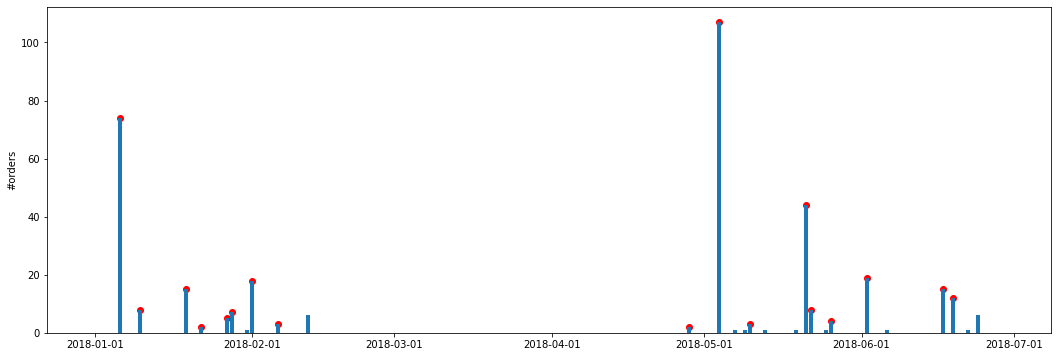

In [67]:
# number of orders per day (examplary product)
item = agg_orders.loc[672]
idx = pd.date_range('2018-01-01', '2018-06-29')
item.index = pd.DatetimeIndex(item.index)
item = item.reindex(idx, fill_value=0)
item.index = pd.to_datetime(item.index)

# apply standard scaling to data
data = item[['order']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model = IsolationForest(contamination=0.1)
model.fit(data)
item['outlier'] = model.predict(data)

# plot figure and outliers
fig, ax = plt.subplots(figsize=(18, 6))
outlier = item.loc[item['outlier'] == -1, ['order']]
ax.bar(item.index.values, item['order'])
ax.scatter(outlier.index.values, outlier['order'], color='red', label='Outlier')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('#orders')
plt.show()